# 2024-02-03 blog: Quantifying and Combining Crypto Alphas
https://robotwealth.com/quantifying-and-combining-crypto-alphas/

In [1]:
# session  options
options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

library(tidyverse)
library(tibbletime)
library(roll)
library(patchwork)

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘tibbletime’


The following object is masked from ‘package:stats’:

    filter




In [2]:
perps <- read_csv("https://github.com/Robot-Wealth/r-quant-recipes/raw/master/quantifying-combining-alphas/binance_perp_daily.csv")
# head(perps)

perps %>%
  filter (ticker == "BTCUSDT") %>%
  tail()

Rows: 187251 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (9): open, high, low, close, dollar_volume, num_trades, taker_buy_volum...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ticker,date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,funding_rate
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2024-02-08,43057.7,45450.0,42992.2,45406.3,15566736863,3919066,181038.5,8036868484,-0.00019125
BTCUSDT,2024-02-09,45406.4,47699.5,44878.0,47136.9,21567170395,5043069,236164.3,10963448921,-0.00022961
BTCUSDT,2024-02-10,47137.0,48230.3,46836.4,47332.0,11649406875,2944511,124731.8,5914214929,-0.00028041
BTCUSDT,2024-02-11,47331.9,48600.0,47139.0,48140.8,11261669160,3007517,117939.9,5660935220,-0.00030000
BTCUSDT,2024-02-12,48140.7,49965.3,47702.0,49925.4,15752123347,3902871,167342.8,8128532918,-0.00030000
BTCUSDT,2024-02-13,49925.5,50428.8,48356.0,48753.1,22702991577,5468794,223860.1,11119813668,-0.00030000


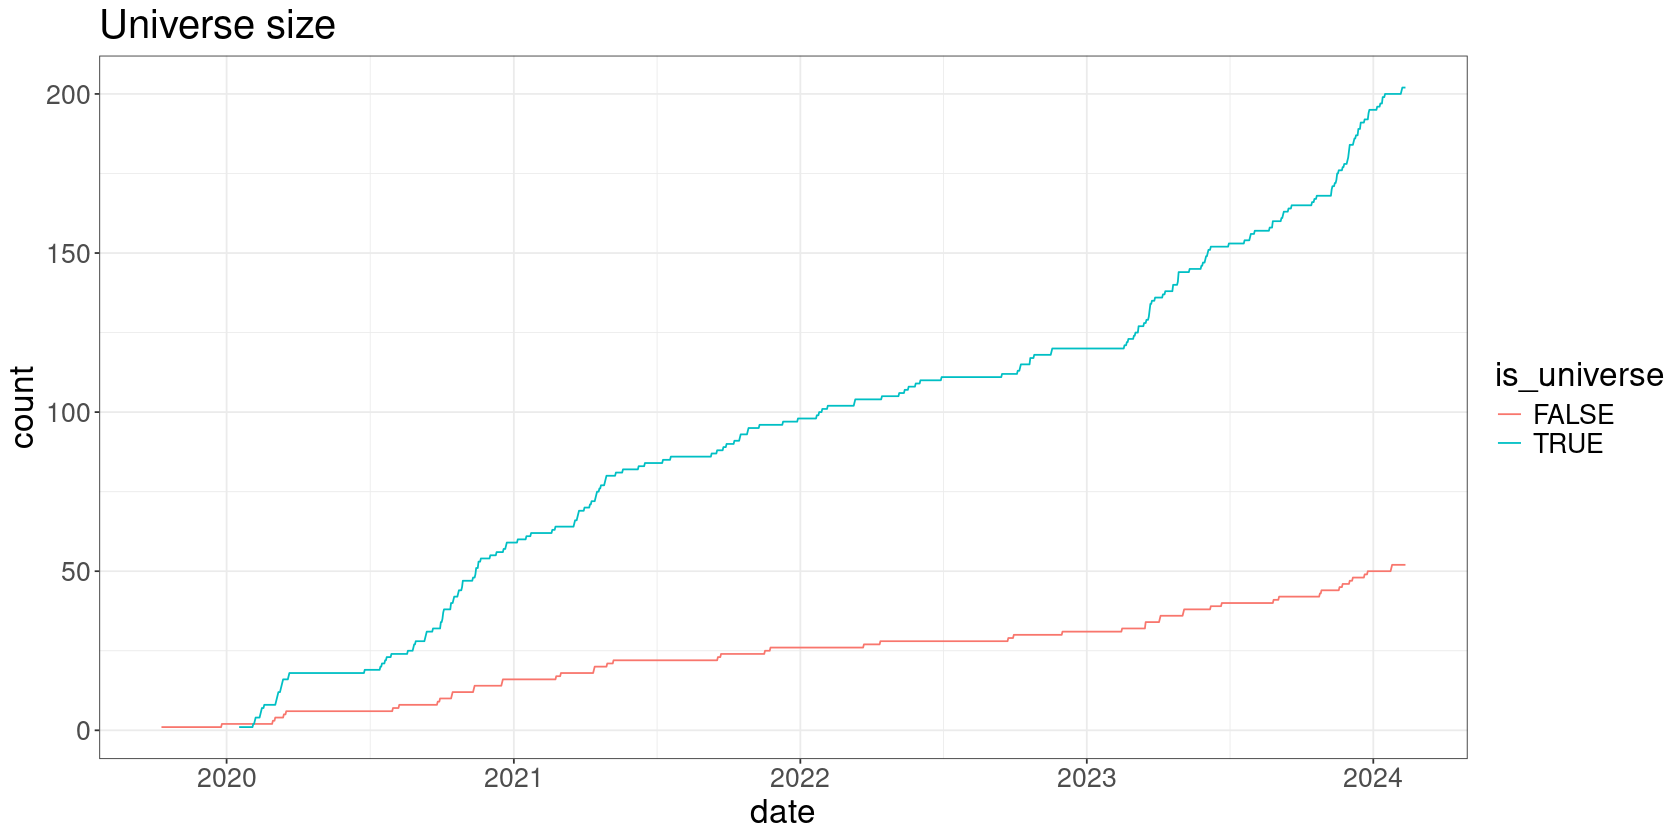

In [3]:
universe <- perps %>%
  group_by(ticker) %>%
  mutate(trail_volume = roll_mean(dollar_volume, 30)) %>%
  # also calculate returns for later
  mutate(
    total_fwd_return_simple = dplyr::lead(funding_rate, 1) + (dplyr::lead(close, 1) - close)/close,  # next day's simple return
    total_fwd_return_simple_2 = dplyr::lead(total_fwd_return_simple, 1),  # next day again simple return
    total_fwd_return_log = log(1 + total_fwd_return_simple)
  ) %>%
  na.omit() %>%
  group_by(date) %>%
  mutate(
    volume_decile = ntile(trail_volume, 10),
    is_universe = volume_decile >= 3
  )

universe %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  ggplot(aes(x=date, y=count, color = is_universe)) +
  geom_line() +
  labs(
    title = 'Universe size'
)

In [4]:
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 20, na_value = NA),
  otherwise = NA
)

features <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    # we won't lag features here because we're using forward returns
    breakout = 9.5 - rolling_days_since_high_20(close),  # puts this feature on a scale -9.5 to +9.5 (9.5 = high was today)
    momo = close - lag(close, 10)/close,
    carry = funding_rate,
    delta = -taker_buy_volume + (num_trades - taker_buy_volume)
  ) %>%
  ungroup() %>%
  na.omit()

head(features)

ticker,date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,⋯,trail_volume,total_fwd_return_simple,total_fwd_return_simple_2,total_fwd_return_log,volume_decile,is_universe,breakout,momo,carry,delta
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2019-10-29,9389.98,9569.10,9156.03,9354.63,1207496201,238440,63093.62,592624390,⋯,640692193,-0.02797496,0.011791818,-0.02837371,1,FALSE,7.5,9353.776,-0.00117130,112252.8
BTCUSDT,2019-10-30,9352.65,9492.86,8975.72,9102.91,1089606006,267844,58062.12,537610627,⋯,660931006,0.01179182,-0.015317479,0.01172284,1,FALSE,6.5,9102.029,-0.00106636,151719.8
BTCUSDT,2019-10-31,9103.86,9438.64,8933.00,9218.70,851802094,229216,46234.79,423883668,⋯,680429873,-0.01531748,0.025637957,-0.01543600,1,FALSE,5.5,9217.811,-0.00092829,136746.4
BTCUSDT,2019-11-01,9218.70,9280.00,9011.00,9084.37,816001159,233091,43506.69,398347973,⋯,698120233,0.02563796,-0.015217382,0.02531482,1,FALSE,4.5,9083.466,-0.00074601,146077.6
BTCUSDT,2019-11-02,9084.37,9375.00,9050.27,9320.00,653539543,204338,35617.67,328788833,⋯,710903610,-0.01521738,0.011864661,-0.01533435,1,FALSE,3.5,9319.204,-0.00030000,133102.7
BTCUSDT,2019-11-03,9319.00,9366.69,9105.00,9180.97,609237501,219662,31698.32,292888566,⋯,722483703,0.01186466,0.008212094,0.01179483,1,FALSE,2.5,9180.160,-0.00030000,156265.4


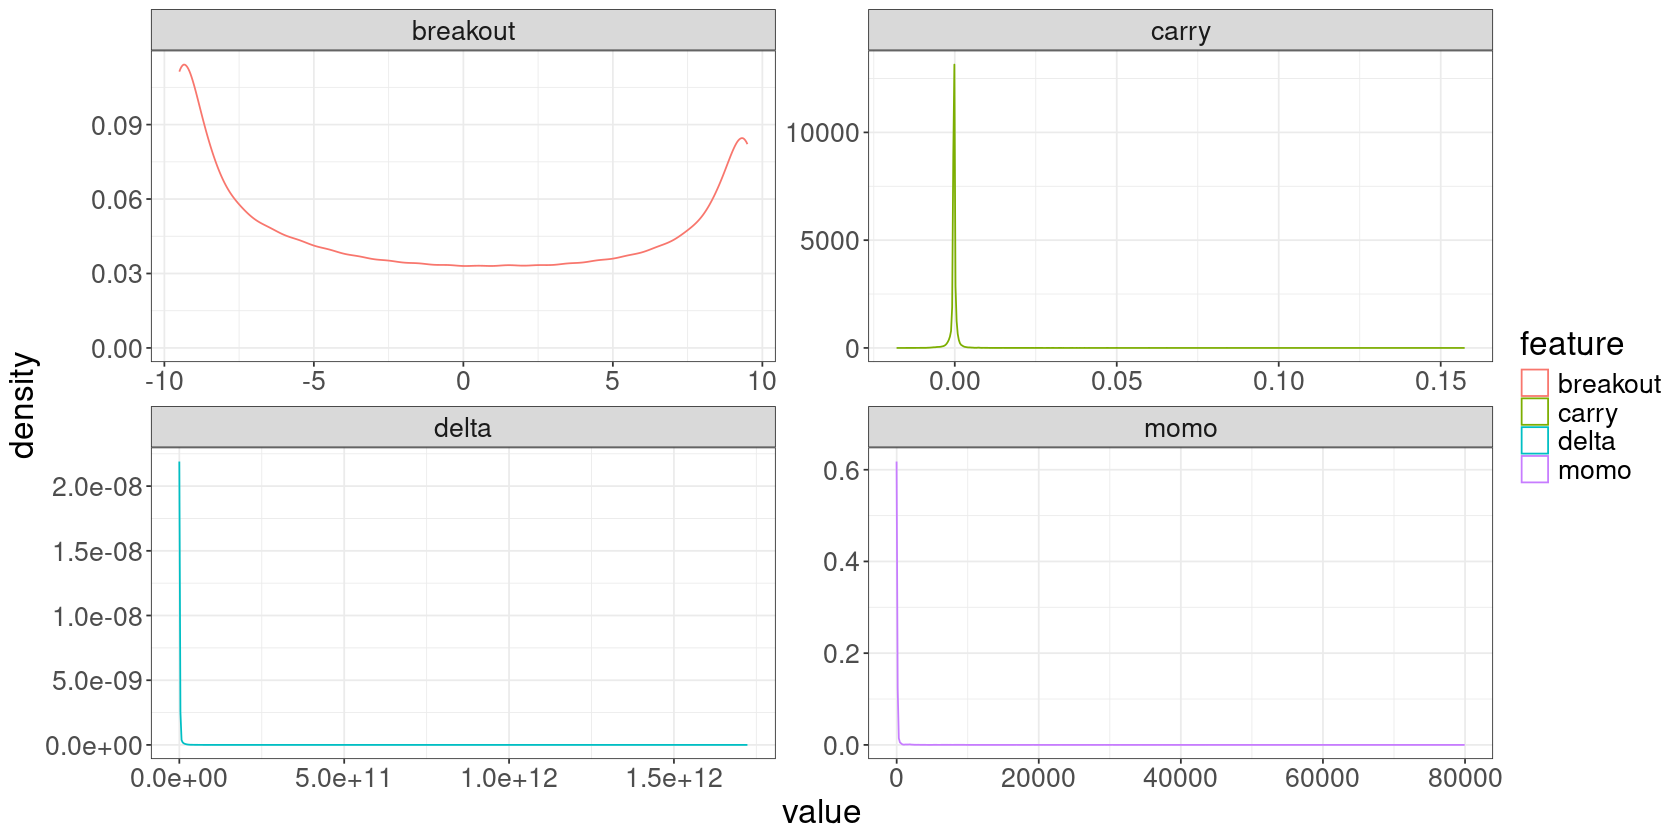

In [20]:
features %>%
  filter(is_universe) %>%
  pivot_longer(c(breakout, momo, carry, delta), names_to = "feature") %>%
  ggplot(aes(x = value, colour = feature)) +
  geom_density() +
  facet_wrap(~feature, scales = "free")

In [42]:
features_scaled <- features %>%
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    demeaned_fwd_returns = total_fwd_return_simple - mean(total_fwd_return_simple),
    zscore_carry = (carry - mean(carry, na.rm = TRUE)) / sd(carry, na.rm = TRUE),
    decile_carry = ntile(carry, 10),
    zscore_momo = (momo - mean(momo, na.rm = TRUE)) / sd(momo, na.rm = TRUE),
    decile_momo = ntile(momo, 10),
    zscore_delta = (delta - mean(delta, na.rm = TRUE)) / sd(delta, na.rm = TRUE),
    decile_delta = ntile(delta, 10),
  ) %>%
  na.omit() %>%
  ungroup()

## Delta

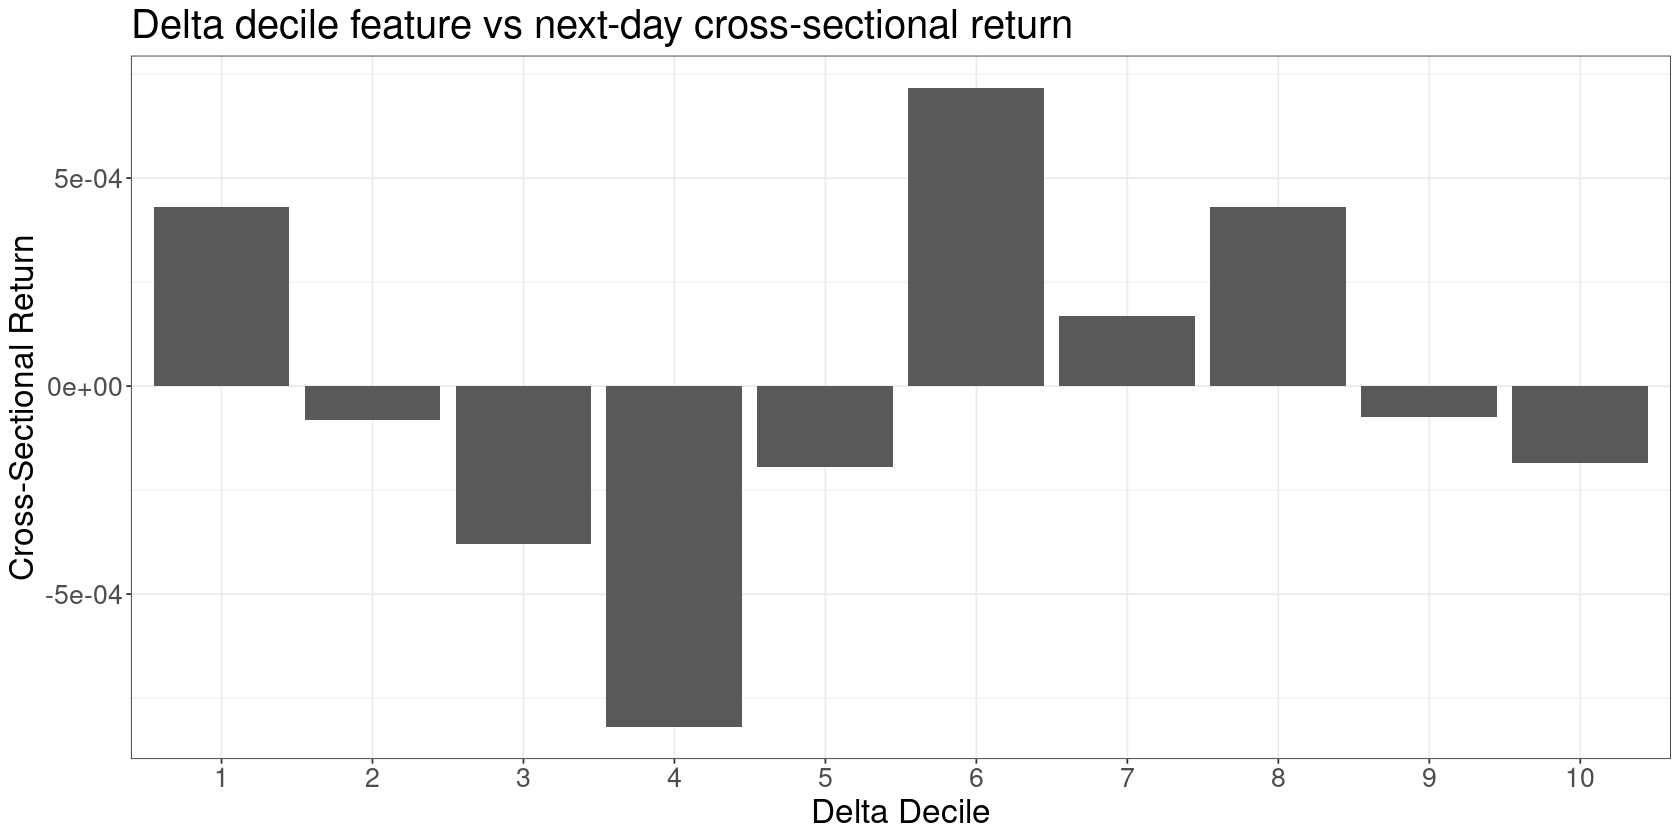

In [43]:
features_scaled %>%
  group_by(decile_delta) %>%
  summarise(
    mean_return = mean(mean(demeaned_fwd_returns))
  ) %>%
  ggplot(aes(x = factor(decile_delta), y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Delta Decile",
    y = "Cross-Sectional Return",
    title = "Delta decile feature vs next-day cross-sectional return"
  )

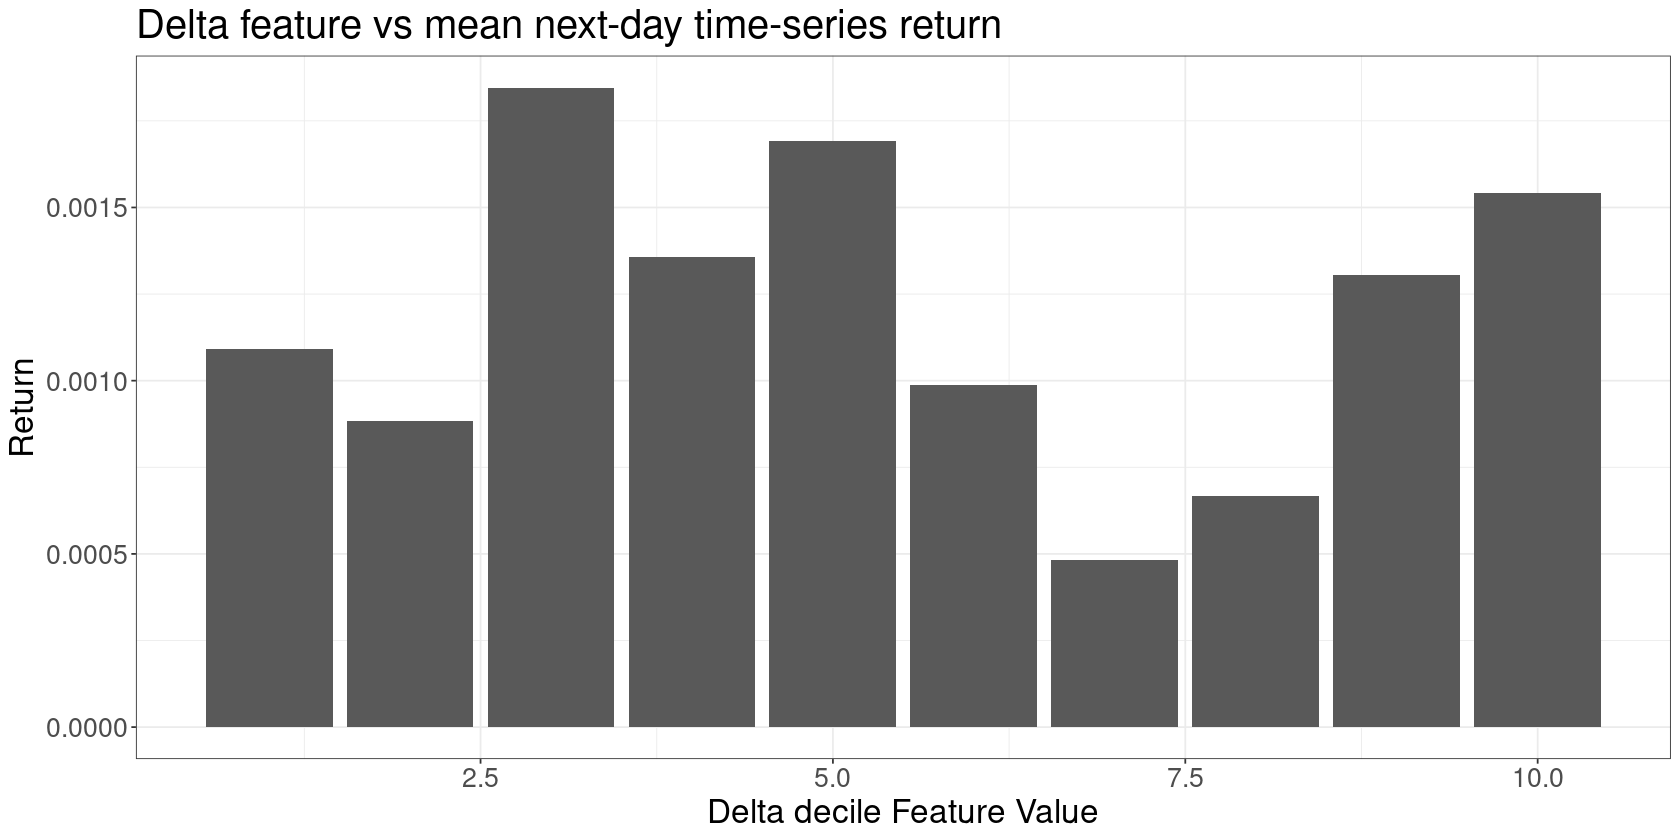

In [31]:
features_scaled %>%
  group_by(decile_delta) %>%
  summarise(
    mean_return = mean(total_fwd_return_simple)
  ) %>%
  ggplot(aes(x = decile_delta, y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Delta decile Feature Value",
    y = "Return",
    title = "Delta feature vs mean next-day time-series return"
  )

## Carry

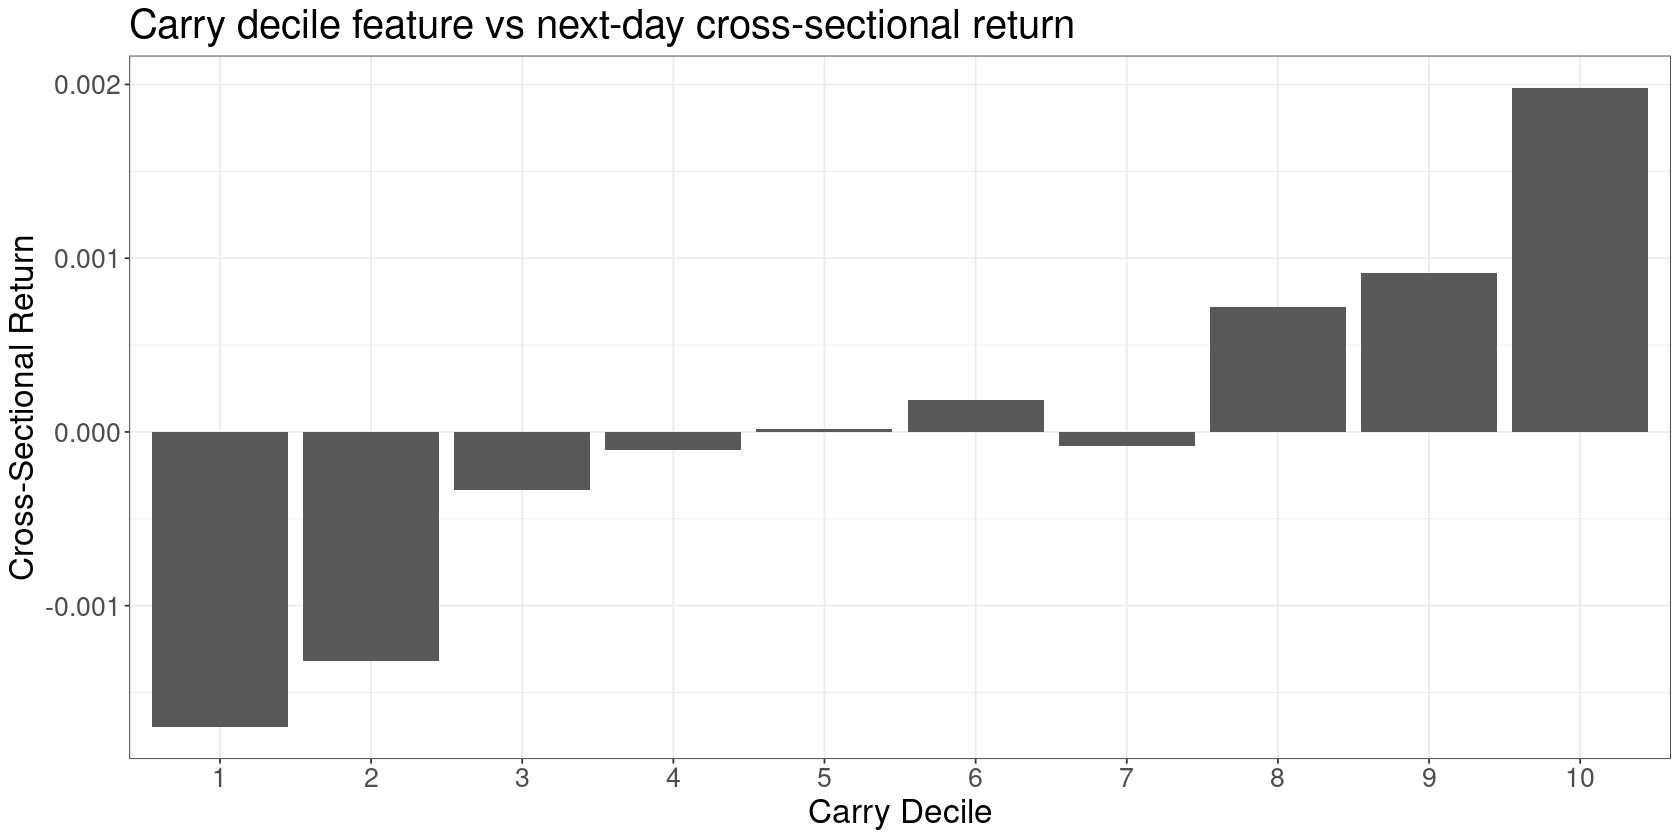

In [7]:
features_scaled %>%
  group_by(decile_carry) %>%
  summarise(
    mean_return = mean(mean(demeaned_fwd_returns))
  ) %>%
  ggplot(aes(x = factor(decile_carry), y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Carry Decile",
    y = "Cross-Sectional Return",
    title = "Carry decile feature vs next-day cross-sectional return"
  )

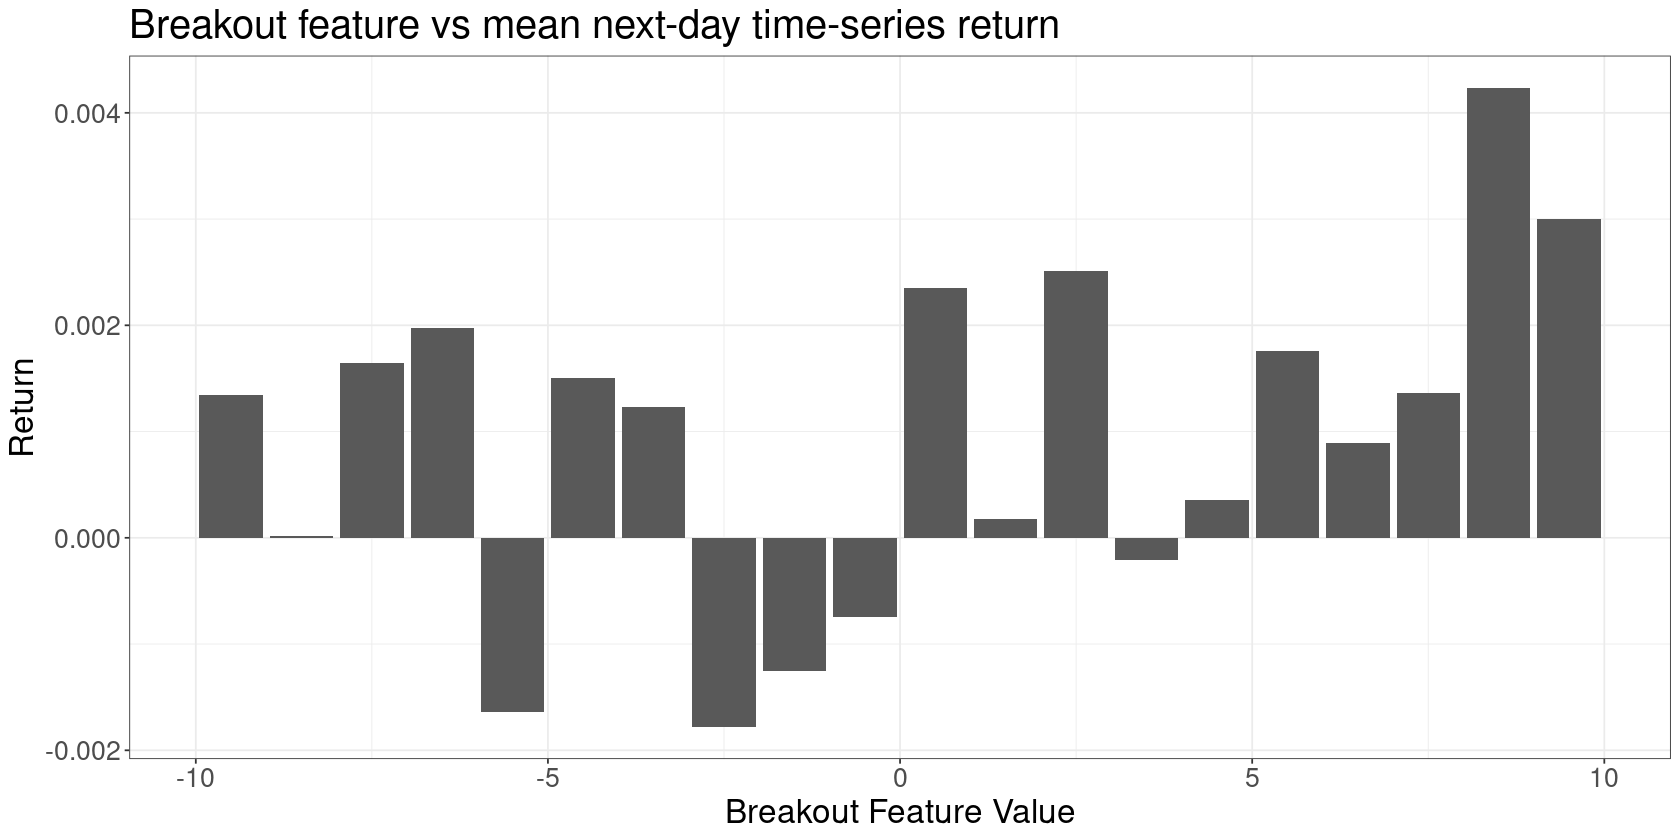

In [8]:
features_scaled %>%
  group_by(breakout) %>%
  summarise(
    mean_return = mean(total_fwd_return_simple)
  ) %>%
  ggplot(aes(x = breakout, y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Breakout Feature Value",
    y = "Return",
    title = "Breakout feature vs mean next-day time-series return"
  )

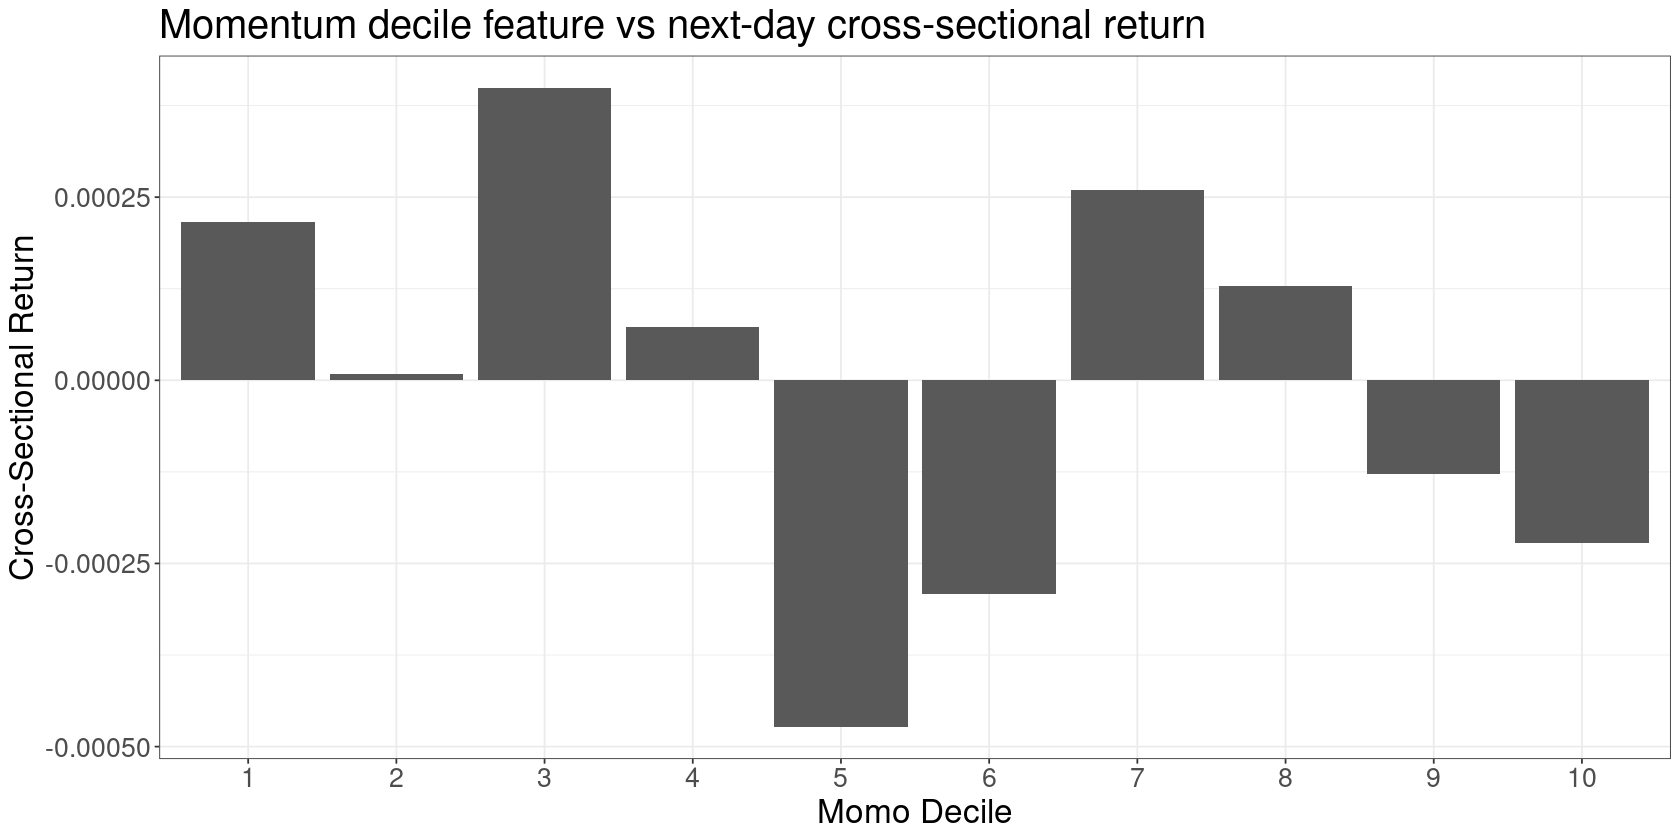

In [9]:
features_scaled %>%
  group_by(decile_momo) %>%
  summarise(
    mean_return = mean(demeaned_fwd_returns)
  ) %>%
  ggplot(aes(x = factor(decile_momo), y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Momo Decile",
    y = "Cross-Sectional Return",
    title = "Momentum decile feature vs next-day cross-sectional return"
  )

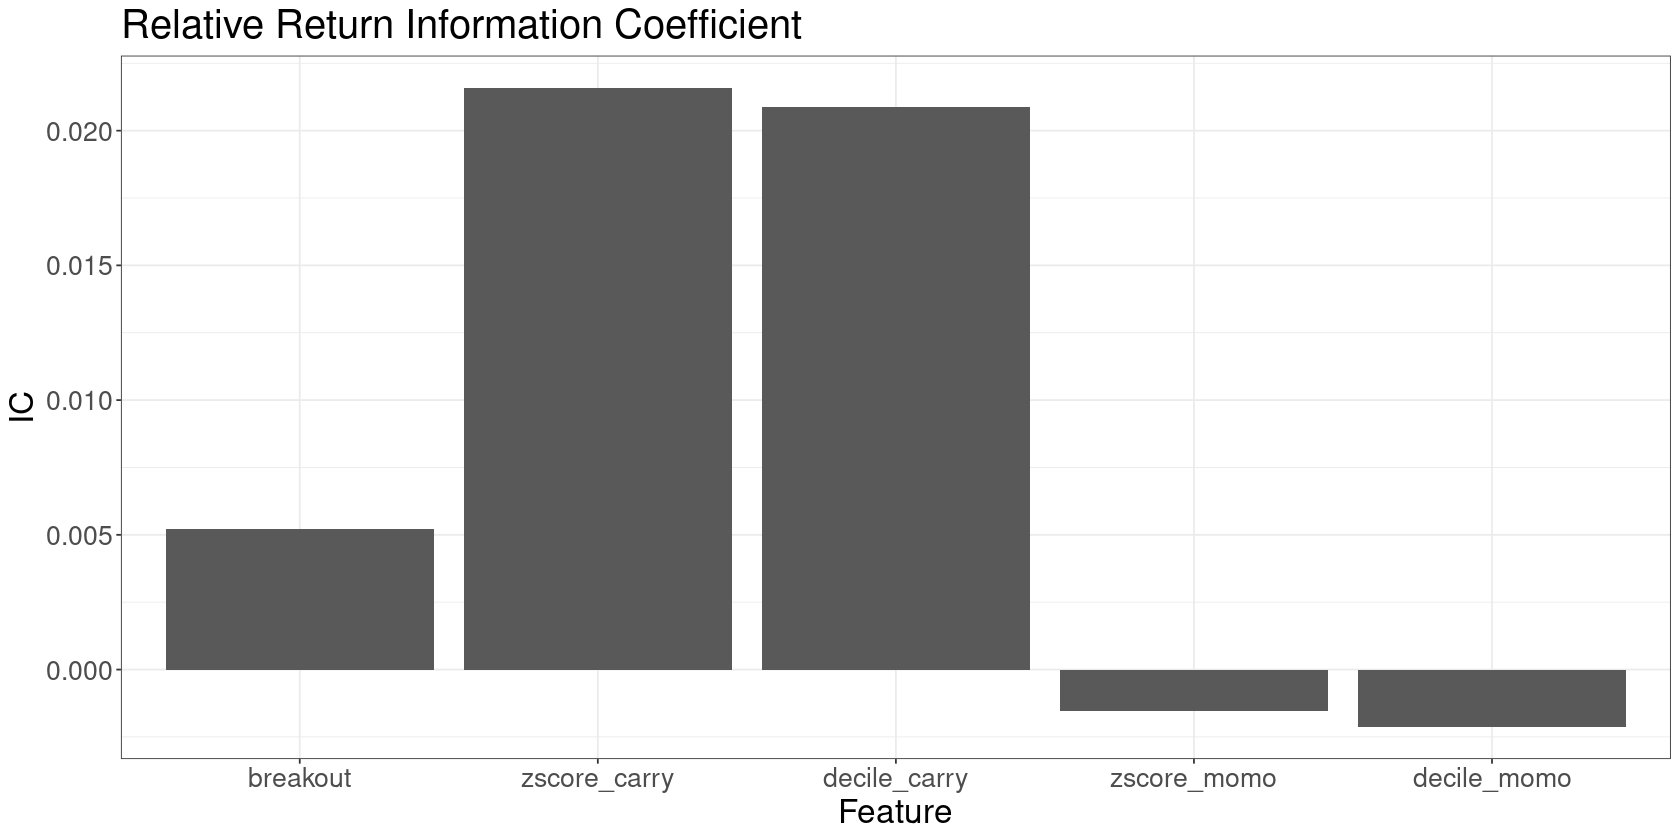

In [10]:
features_scaled %>%
  pivot_longer(c(breakout, zscore_carry, zscore_momo, decile_carry, decile_momo), names_to = "feature") %>%
  group_by(feature) %>%
  summarize(IC = cor(value, demeaned_fwd_returns))  %>%
  ggplot(aes(x = factor(feature, levels = c('breakout', 'zscore_carry', 'decile_carry', 'zscore_momo', 'decile_momo')), y = IC)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Feature",
    y = "IC",
    title = "Relative Return Information Coefficient"
  )

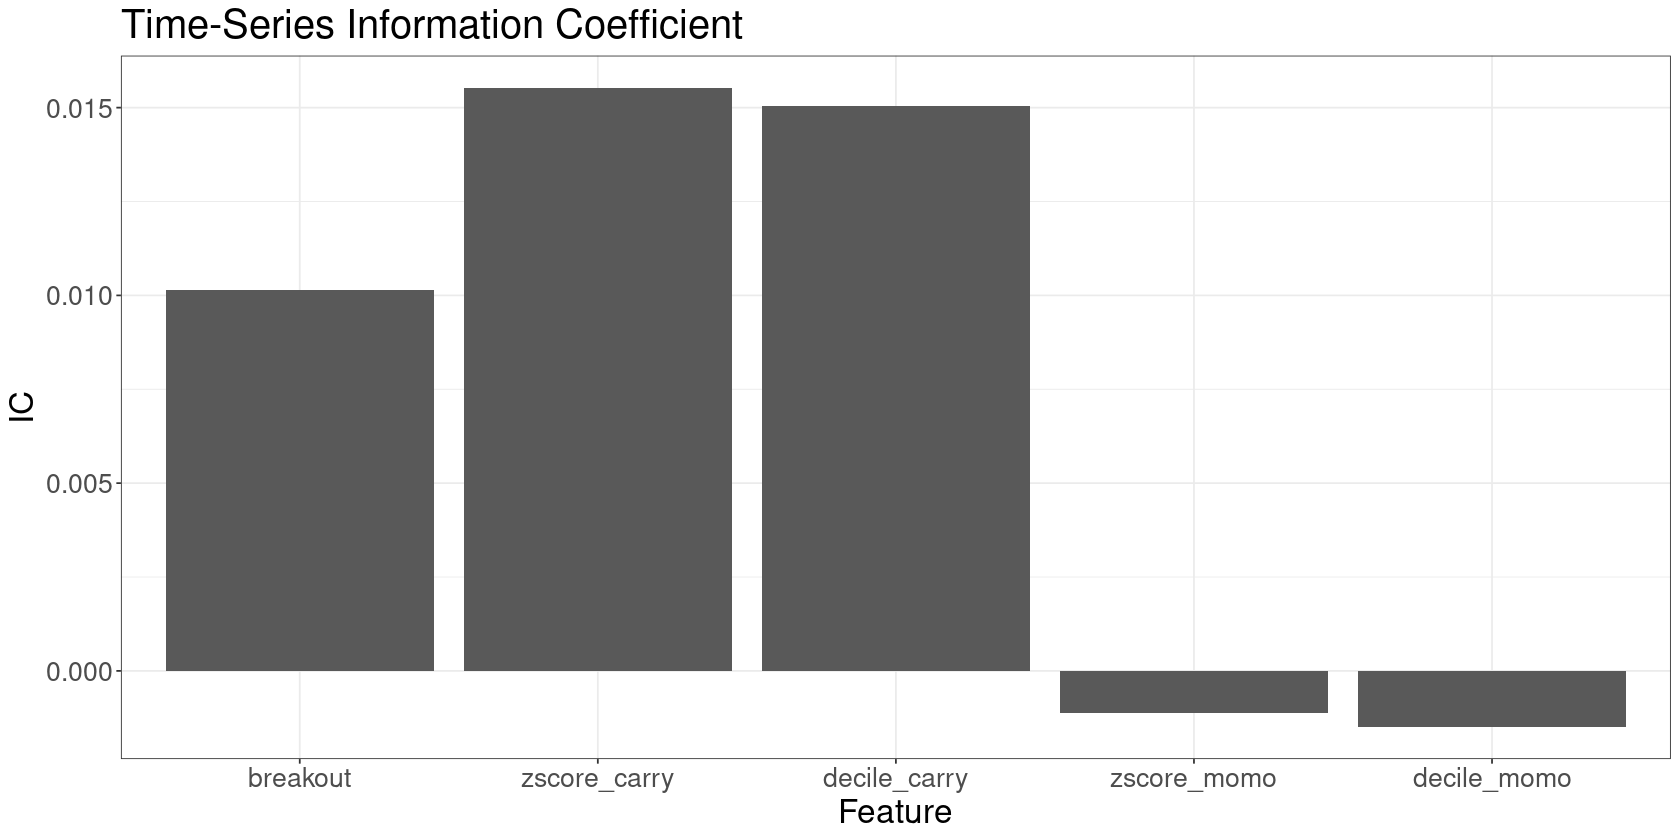

In [11]:
features_scaled %>%
  pivot_longer(c(breakout, zscore_carry, zscore_momo, decile_carry, decile_momo), names_to = "feature") %>%
  group_by(feature) %>%
  summarize(IC = cor(value, total_fwd_return_simple))  %>%
  ggplot(aes(x = factor(feature, levels = c('breakout', 'zscore_carry', 'decile_carry', 'zscore_momo', 'decile_momo')), y = IC)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Feature",
    y = "IC",
    title = "Time-Series Information Coefficient"
  )

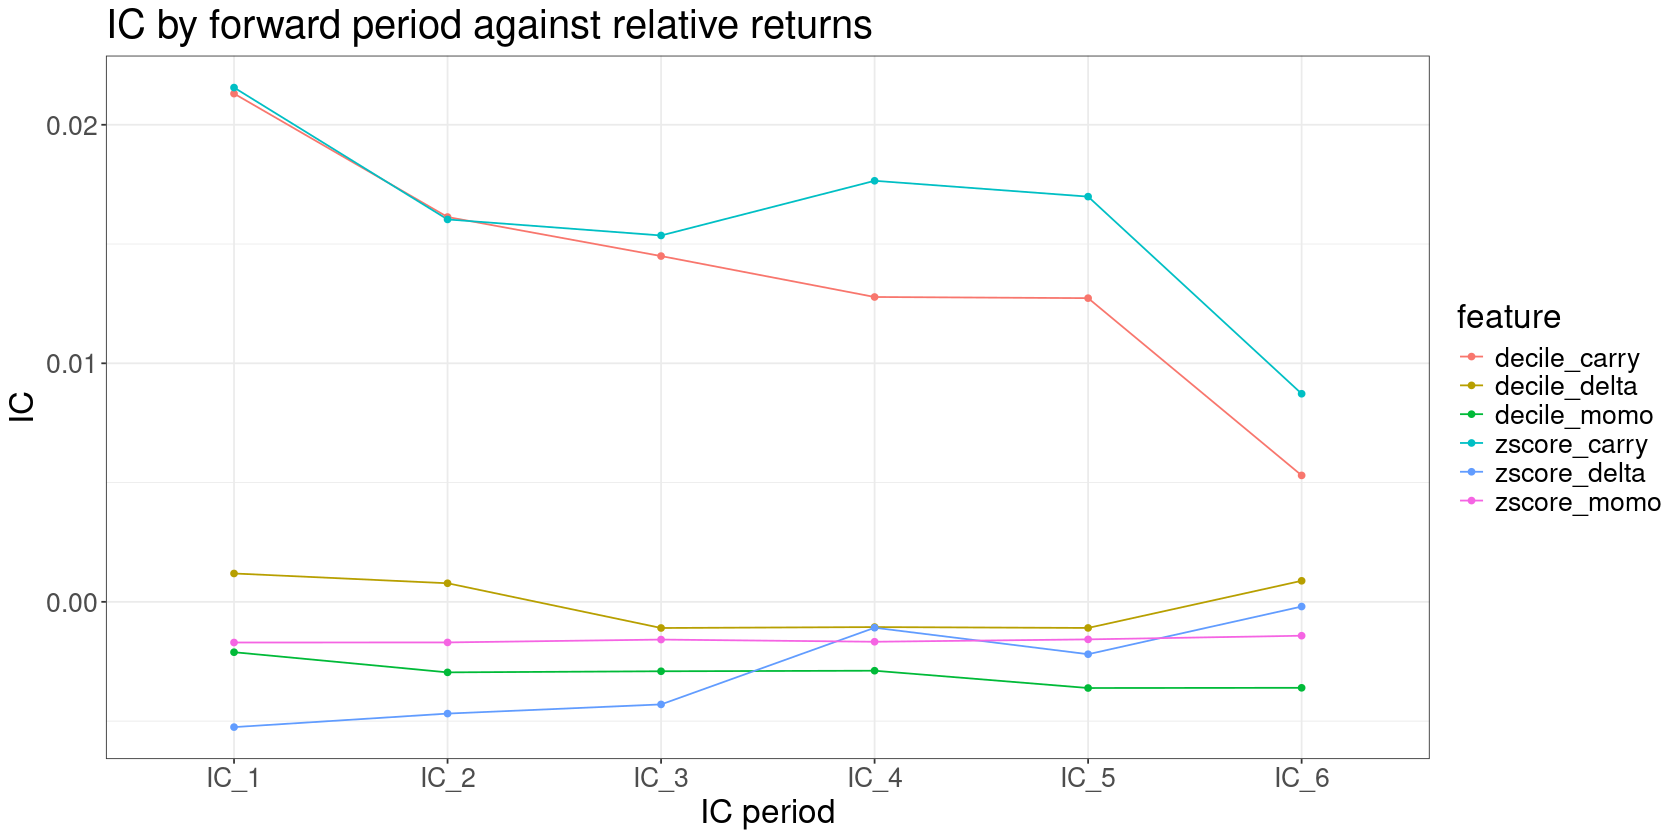

In [44]:
features_scaled %>%
  filter(is_universe) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    demeaned_fwd_returns_2 = lead(demeaned_fwd_returns, 1),
    demeaned_fwd_returns_3 = lead(demeaned_fwd_returns, 2),
    demeaned_fwd_returns_4 = lead(demeaned_fwd_returns, 3),
    demeaned_fwd_returns_5 = lead(demeaned_fwd_returns, 4),
    demeaned_fwd_returns_6 = lead(demeaned_fwd_returns, 5),
  ) %>%
  na.omit() %>%
  ungroup() %>%
  pivot_longer(c(zscore_carry, zscore_momo, decile_carry, decile_momo, zscore_delta, decile_delta), names_to = "feature") %>%
  group_by(feature) %>%
  summarize(
    IC_1 = cor(value, demeaned_fwd_returns),
    IC_2 = cor(value, demeaned_fwd_returns_2),
    IC_3 = cor(value, demeaned_fwd_returns_3),
    IC_4 = cor(value, demeaned_fwd_returns_4),
    IC_5 = cor(value, demeaned_fwd_returns_5),
    IC_6 = cor(value, demeaned_fwd_returns_6),
  )  %>%
  pivot_longer(-feature, names_to = "IC_period", values_to = "IC") %>%
  ggplot(aes(x = factor(IC_period), y = IC, colour = feature, group = feature)) +
  geom_line() +
  geom_point() +
  labs(
    title = "IC by forward period against relative returns",
    x = "IC period"
  )

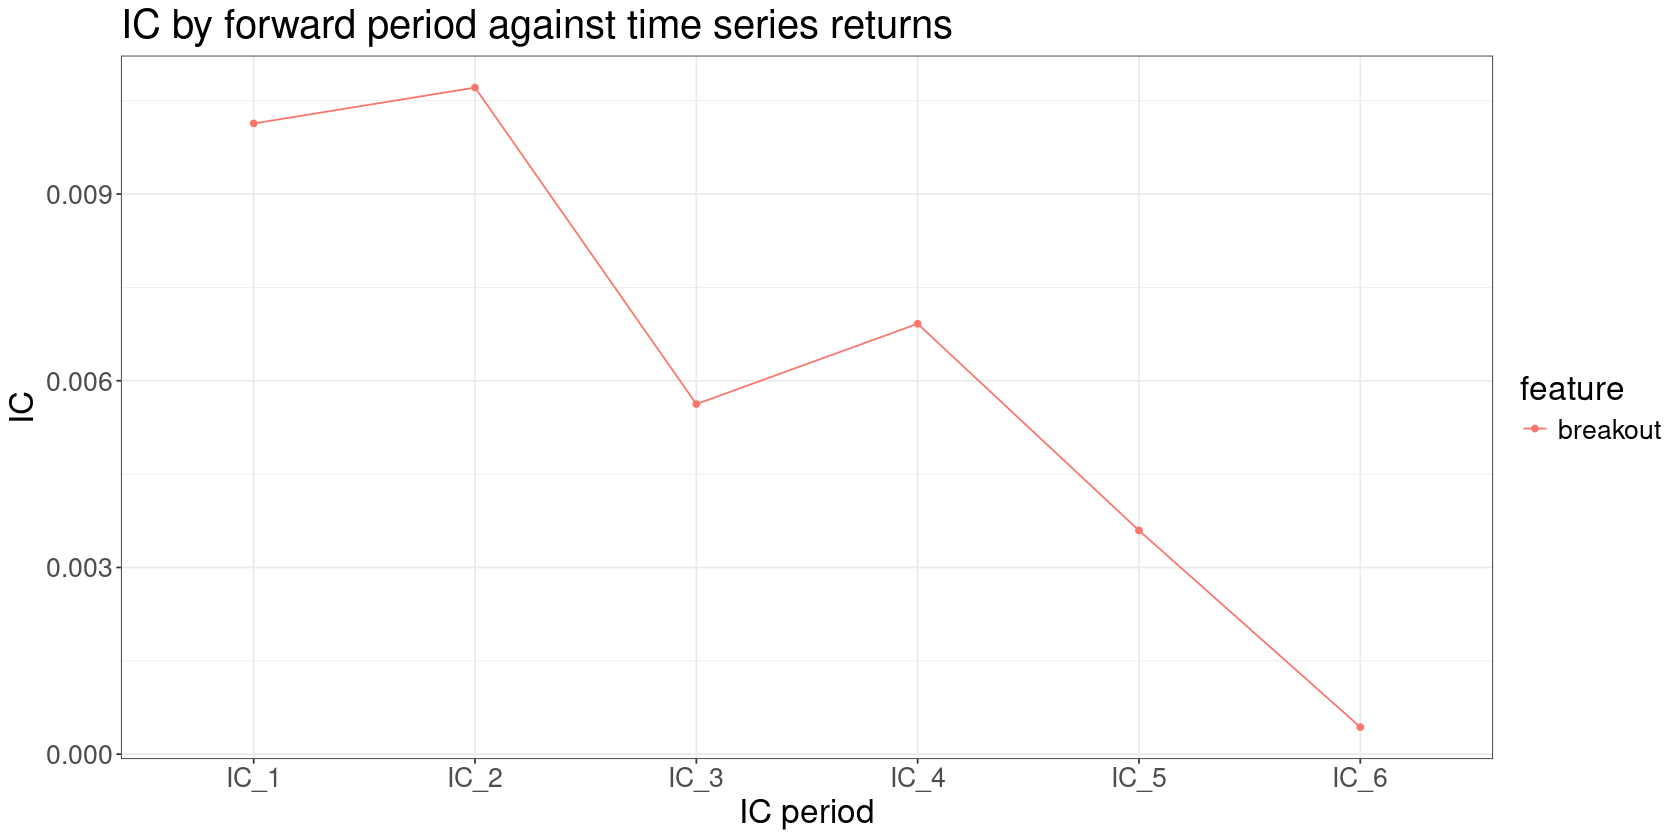

In [33]:
features_scaled %>%
  group_by(ticker) %>%
  mutate(
    fwd_returns_2 = lead(total_fwd_return_simple, 1),
    fwd_returns_3 = lead(total_fwd_return_simple, 2),
    fwd_returns_4 = lead(total_fwd_return_simple, 3),
    fwd_returns_5 = lead(total_fwd_return_simple, 4),
    fwd_returns_6 = lead(total_fwd_return_simple, 5),
  ) %>%
  na.omit() %>%
  ungroup() %>%
  pivot_longer(c(breakout), names_to = "feature") %>%
  group_by(feature) %>%
  summarize(
    IC_1 = cor(value, total_fwd_return_simple),
    IC_2 = cor(value, fwd_returns_2),
    IC_3 = cor(value, fwd_returns_3),
    IC_4 = cor(value, fwd_returns_4),
    IC_5 = cor(value, fwd_returns_5),
    IC_6 = cor(value, fwd_returns_6),
  )  %>%
  pivot_longer(-feature, names_to = "IC_period", values_to = "IC") %>%
  ggplot(aes(x = factor(IC_period), y = IC, colour = feature, group = feature)) +
  geom_line() +
  geom_point() +
  labs(
    title = "IC by forward period against time series returns",
    x = "IC period"
  )

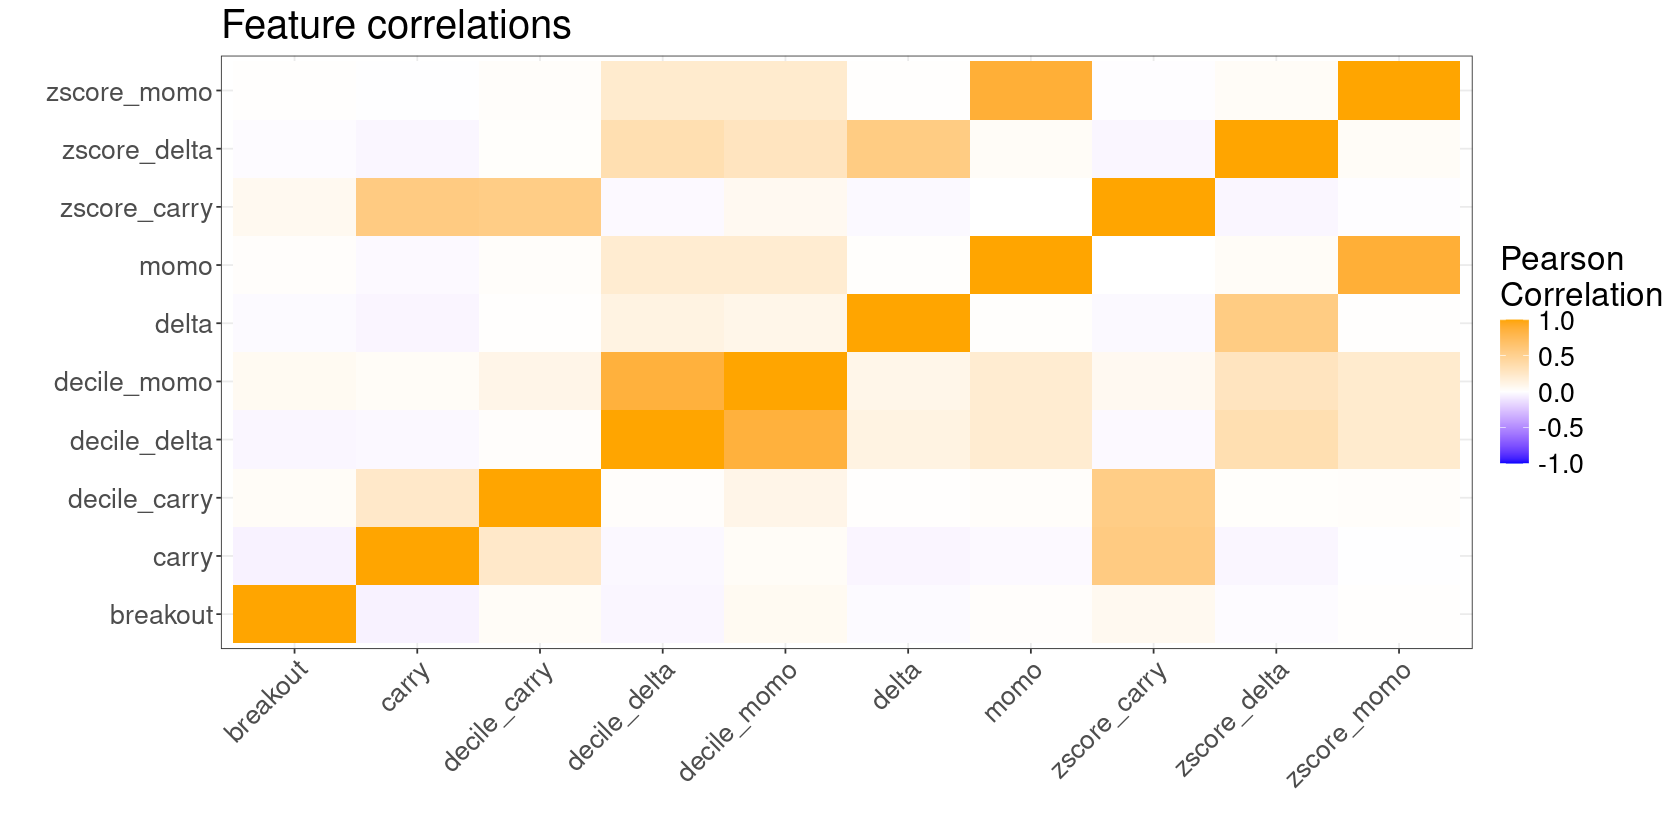

In [45]:
features_scaled %>%
  select('breakout', 'momo', 'carry', 'delta', 'zscore_carry', 'decile_carry', 'zscore_momo', 'decile_momo','zscore_delta', 'decile_delta') %>%
  as.matrix() %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("feature1") %>%
  pivot_longer(-feature1, names_to = "feature2", values_to = "corr") %>%
  ggplot(aes(x = feature1 , y = feature2, fill = corr)) +
  geom_tile() +
  scale_fill_gradient2(
    low = "blue",
    high = "orange",
    mid = "white",
    midpoint = 0,
    limit = c(-1,1),
    name="Pearson\nCorrelation"
  ) +
  labs(
    x = "",
    y = "",
    title = "Feature correlations"
  ) +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 16, hjust = 1))

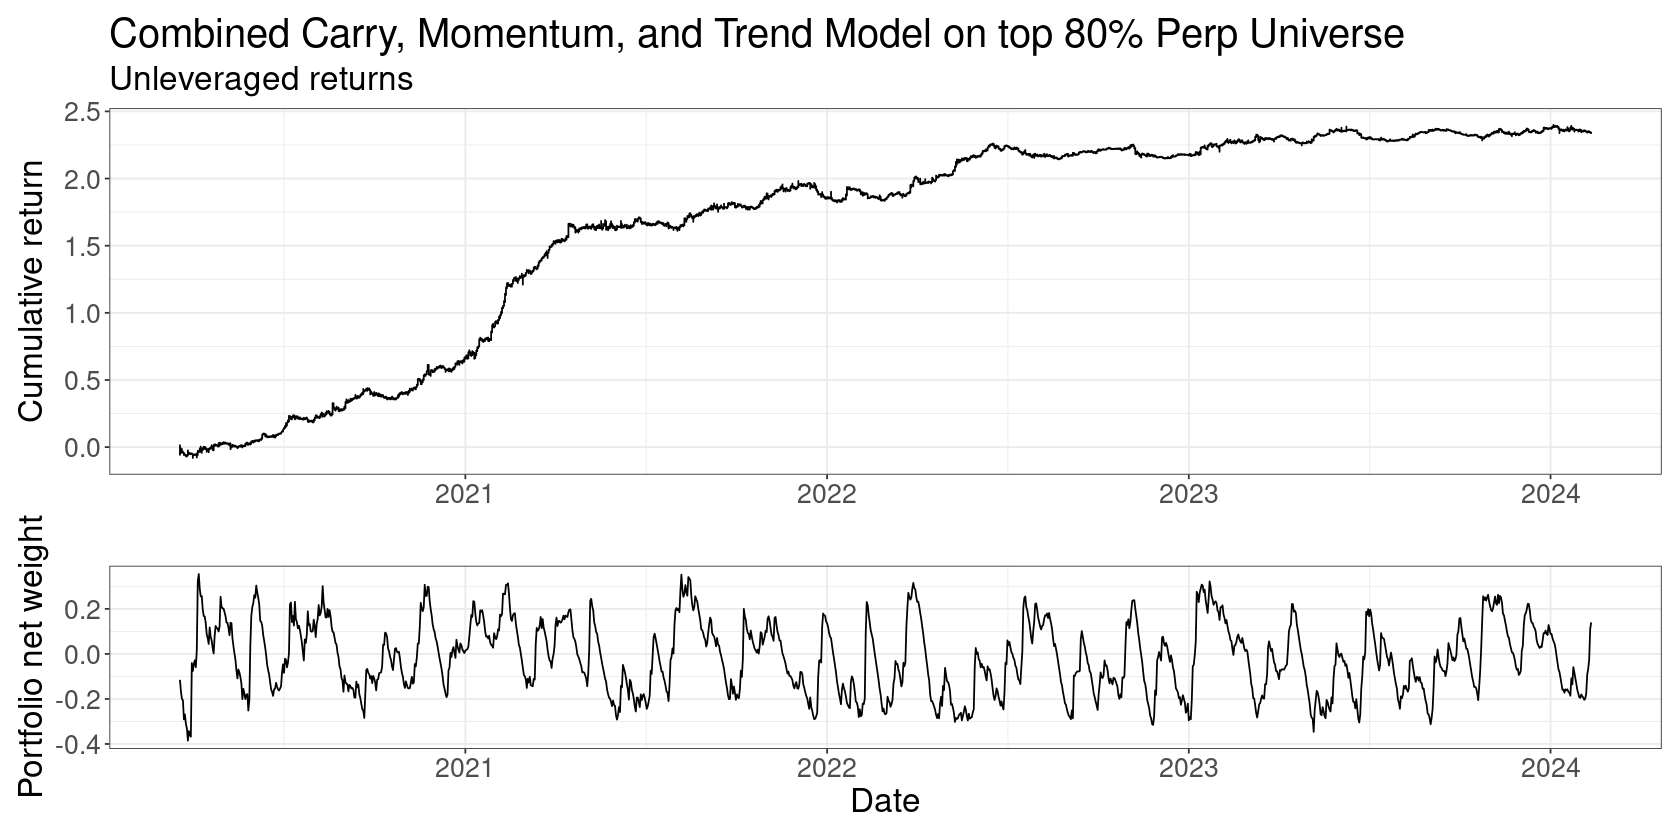

In [59]:
# start simulation from date we first have n tickers in the universe
min_trading_universe_size <- 10
start_date <- features %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  filter(count >= min_trading_universe_size) %>%
  head(1) %>%
  pull(date)

model_df <- features %>%
  filter(is_universe) %>%
  filter(date >= start_date) %>%
  group_by(date) %>%
  mutate(
    carry_decile = ntile(carry, 10),
    carry_weight = (carry_decile - 5.5),  # will run -4.5 to 4.5
    momo_decile = ntile(momo, 10),
    momo_weight = -(momo_decile - 5.5),  # will run -4.5 to 4.5
    delta_decile = ntile(delta, 10),
    delta_weight = (delta_decile - 5.5),
    breakout_weight = breakout / 2,   # TODO: probably don't actually want to allow a short position based on the breakout feature
    # combined_weight = (0.5*carry_weight + 0.2*delta_weight +0.2*momo_weight + 0.1*breakout_weight),
    combined_weight = (0.5*carry_weight + 0.4*momo_weight + 0.1*breakout_weight),
    # combined_weight = (0.5*carry_weight + 0.2*momo_weight + 0.3*breakout_weight),
    # scale weights so that abs values sum to 1 - no leverage condition
    scaled_weight = if_else(combined_weight == 0, 0, combined_weight/sum(abs(combined_weight)))
  )

returns_plot <- model_df %>%
  summarize(returns = scaled_weight * total_fwd_return_simple, .groups = "drop") %>%
  mutate(logreturns = log(returns+1)) %>%
  ggplot(aes(x=date, y=cumsum(logreturns))) +
  geom_line() +
  labs(
    title = 'Combined Carry, Momentum, and Trend Model on top 80% Perp Universe',
    subtitle = "Unleveraged returns",
    x = "",
    y = "Cumulative return"
  )

weights_plot <- model_df %>%
  group_by(date) %>%
  summarise(total_weight = sum(scaled_weight)) %>%
  ggplot(aes(x = date, y = total_weight)) +
  geom_line() +
  labs(x = "Date", y = "Portfolio net weight")

returns_plot / weights_plot + plot_layout(heights = c(2,1))

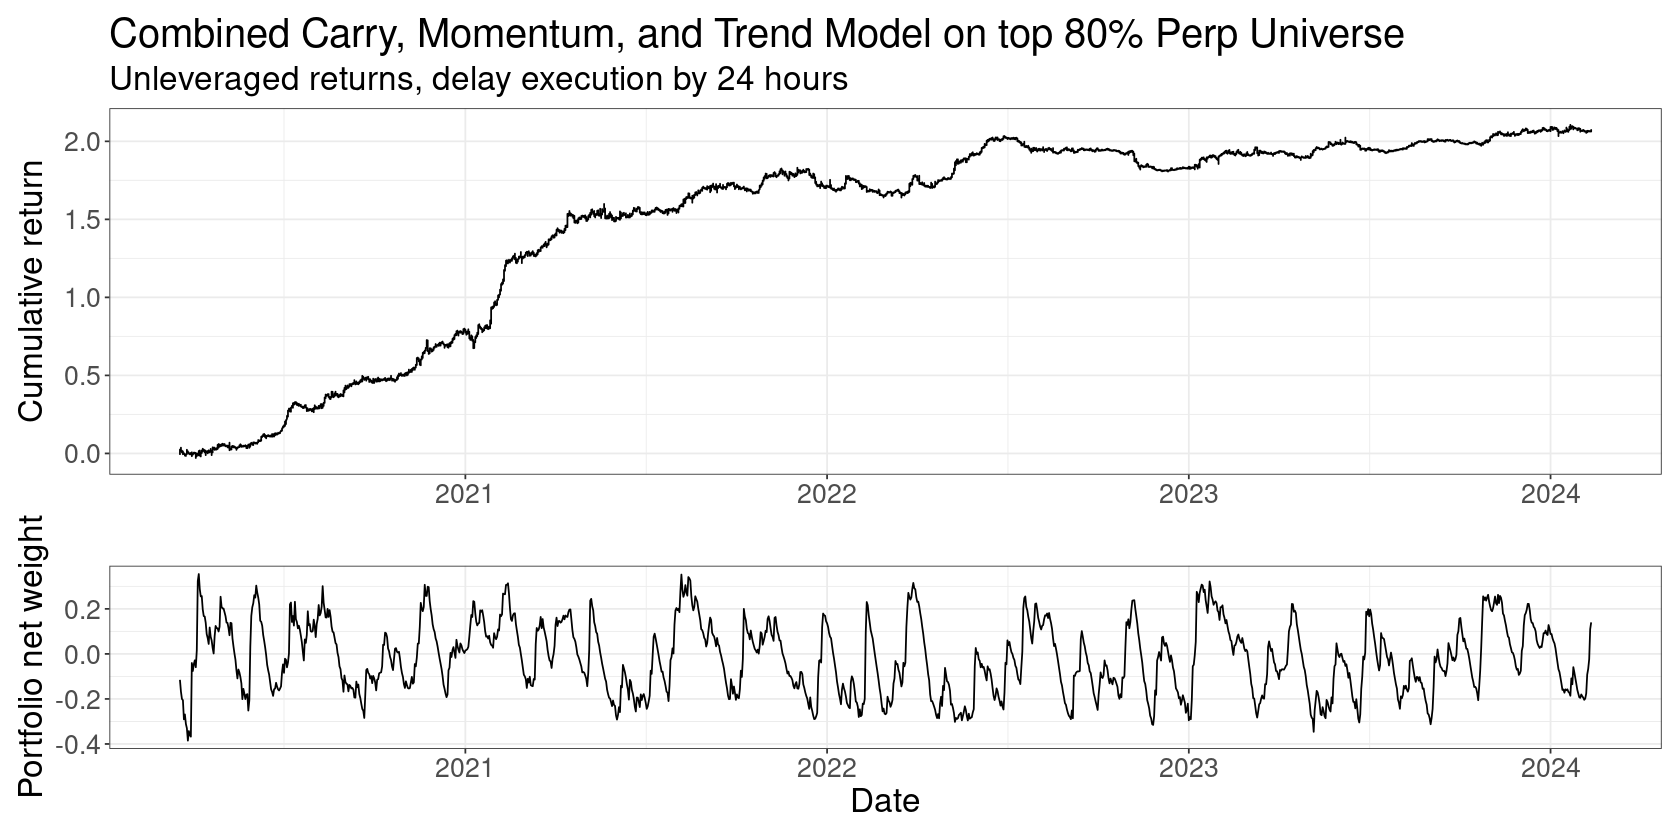

In [60]:
returns_plot <- model_df %>%
  summarize(returns = scaled_weight * total_fwd_return_simple_2, .groups = "drop") %>%
  mutate(logreturns = log(returns+1)) %>%
  ggplot(aes(x=date, y=cumsum(logreturns))) +
  geom_line() +
  labs(
    title = 'Combined Carry, Momentum, and Trend Model on top 80% Perp Universe',
    subtitle = "Unleveraged returns, delay execution by 24 hours",
    x = "",
    y = "Cumulative return"
  )

weights_plot <- model_df %>%
  group_by(date) %>%
  summarise(total_weight = sum(scaled_weight)) %>%
  ggplot(aes(x = date, y = total_weight)) +
  geom_line() +
  labs(x = "Date", y = "Portfolio net weight")

returns_plot / weights_plot + plot_layout(heights = c(2,1))